In [3]:
import warnings
warnings.filterwarnings('ignore')

from active_tester import ActiveTester
from active_tester.estimators.naive import Naive
from active_tester.estimators.learned import Learned
from active_tester.query_strategy.random import Random
from sklearn.metrics import accuracy_score
import active_tester
import sys
sys.path.append("../")
from simulate_dataset import TestDataset
from sklearn.metrics import accuracy_score
from active_tester.label_estimation.methods import no_oracle, oracle_one_label, oracle_multiple_labels
import seaborn as sns
import matplotlib.pyplot as plt

## Overview

In this notebook, we discuss the two metric estimators that are available in this package, Naive and Learned.

The Naive estimator is simple.  It compares the labels predicted by the system to the noisy labels to compute the metric of interest, unless a vetted label is available, in which case the noisy label is replaced by the vetted label.

The Learned estimator is slightly more complex.  It uses the currently vetted labels to build a model that predicts label probabilities for each item, given the system scores, the noisy labels, and potentially the item features.  These learned probabilities are then compared to the system predictions to estimate the metric of interest.  Because the learned estimator updates our understanding of the ground truth (the label probabilities) for all items in the test set (rather than just the vetted ones) it is potentially much more powerful.

## Using the estimators

The estimator to be used in active testing is specified while creating the active tester object.  It must be passed a function (to the `metric` parameter) to compute the metric of interest.  The function should take as input the true labels and predicted labels.

```python
active_test = ActiveTester(estimator=Naive(metric=accuracy_score), query_strategy=Random())
```

If using the Learned estimator, we must also tell the estimator what method to use to estimate the label probabilities for each item.  There are two options implemented in the package, a supervised approach and an unsupervised approach.

In the supervised approach (set `estimation_method` to `oracle_multiple_labels`, we use the relationship (see __[Active Testing: An Efficient and Robust Framework for Estimating Accuracy](https://icml.cc/Conferences/2018/Schedule?showEvent=2681)__ for the derivation)

$$
p(z_i | s_i,y_i) \propto p(y_i|z_i)p(z_i|s_i),
$$

where $z_i$ is the true label, $s_i$ is the classifier score, and $y_i$ is the noisy label, for the $ith$ item.  We estimate the confusion matrix probabilities $p(y=c_j|z=c_k)$ for $c_j,c_k \in C$, where $C$ is the set of all classes, using the proportion of noisy labels that match the vetted label.  We estimate $p(z|s)$ using logistic regression.

In the unsupervised approach (set `estimation_method` to `no_oracle`), we make use of an estimation technique that infers label probabilities for items from only set of categorical predictions.  In this approach, the vetted labels are not assumed to be correct.

While the methods differ in approach, they both return, for each item, a probability distribution over the classes.

When using the learned estimator, we simply pass the method we would like to use, in addition to the metric.

```python
active_test = ActiveTester(estimator=Learned(metric=accuracy_score, 
                                             estimation_method=oracle_multiple_labels), 
                                         query_strategy=Random())
```

If desired, the Learned estimator can also use the features of the items in the estimation as well.  In this case, the model is

$$
p(z_i | s_i,y_i,x_i) \propto p(y_i|z_i)p(z_i|s_i,x_i).
$$

The main difference is that the logistic regresion model is fit using the features as well.

We can enable this by setting `use_features` to `True` in the initialization of the Learned estimator (by default it is `False`).

```python
active_test = active_tester.ActiveTester(estimator=Learned(metric=accuracy_score, 
                                                           estimation_method=oracle_multiple_labels, 
                                                           use_features=True),
                                         query_strategy=Random())
```

## Comparing the estimators using simulated data

Now that we understand the difference between the estimators, we'll compare them on some simple datasets.  In this package, we've included the ability to build simple simulated data sets and then execute different combinations of active_tester parameters, via the `TestDataset` class.

Below, we initialize the `TestDataset()` object and set a few parameters.  This class wraps an sklearn function to produce the actual dataset.  Calling the `test()` method generates the actual dataset and the noisy labels.  Here, we've chosen to have 1 noisy label per item and to make the noisy labels 60% accurate.

In [4]:
sample_dataset = TestDataset(num_samples=10000, 
                             num_features=10, 
                             num_informative_features=5, 
                             num_classes=4, 
                             num_clusters_per_class=4)
sample_dataset.test(num_experts=1, 
                    expert_accuracy=0.6)

Now that the dataset is constructed, we can call the `compare_estimator_query()` method to run different combinations of strategies and parameters.  This method has a variety of options that we can set to compare different active testing setups.  To briefly explain:
* `estimators`: a list of the estimators to use (choose from 'Learned', 'Naive')
* `query_strategies`: a list of the query strategies to use (choose from 'Random', 'Classifier Uncertainty Greedy','Classifier Uncertainty Sample', 'Classifier Uncertainty Smoothed', 'Noisy Label Uncertainty Greedy', 'Noisy Label Uncertainty Sample', 'Noisy Label Uncertainty Smoothed', 'MCM Greedy', 'MCM Sample', 'MCM Smoothed', 'DPP') 
* `sample_sizes`: a list of the number of items to query and then vet
* `estimation_method`: a list of estimation methods to use (choose from 'Oracle Multiple Labels', 'No Oracle')
* `vetter_acc`: list of oracle accuracies to use.  This parameter sets the accuracy of the vetter.
* `useX`: boolean that describes whether to use the features when fitting the learned estimator
* `num_iterations`: how many times to repeat each combination of strategies and paramters

The method returns a pandas dataframe of errors that we can then use to make plots.  Note that since we are using simulated data where the true labels are actually known, this method will simply choose the correct label for each queried item.

In [5]:
to_plot = sample_dataset.compare_estimator_query(estimators=['Naive','Learned'], 
                                       query_strategies=['Random'],
                                       sample_sizes=[100,200,300,400,500],
                                       estimation_method=['Oracle Multiple Labels'],
                                       num_iterations=50)

Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "96"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "96"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "96"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "96"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "96"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "96"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "96"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "96"
Beginning preprocessing to find 

Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "200" to "196"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "200" to "196"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "200" to "196"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "200" to "196"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "200" to "196"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "200" to "196"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "200" to "196"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "200" to "196"
Beginning preprocessing 

Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "300" to "296"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "300" to "296"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "300" to "296"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "300" to "296"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "300" to "296"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "300" to "296"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "300" to "296"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "300" to "296"
Beginning preprocessing 

Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing 

Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "96"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "96"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "96"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "96"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "96"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "96"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "96"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "100" to "96"
Beginning preprocessing to find 

Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "300" to "296"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "300" to "296"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "300" to "296"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "300" to "296"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "300" to "296"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "300" to "296"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "300" to "296"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "300" to "296"
Beginning preprocessing 

Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "400" to "396"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "400" to "396"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "400" to "396"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "400" to "396"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "400" to "396"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "400" to "396"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "400" to "396"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "400" to "396"
Beginning preprocessing 

Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing 

We clearly see that in this simple example, the Learned estimator has a clear advantage over the Naive estimator.

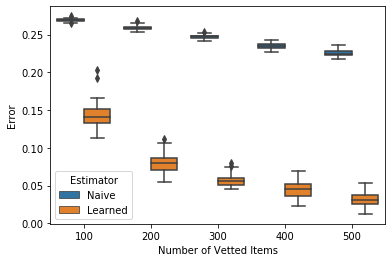

In [6]:
sns.boxplot(x='Number of Vetted Items', y='Error', hue='Estimator', data=to_plot)

Given that the learned estimator can use two different label estimation methods, we also compare the performance of the learned estimator using both.  In this example, we'll show how the label estimation methods perform as the performance of the vetter degrades.

In [7]:
to_plot = sample_dataset.compare_estimator_query(estimators=['Learned'], 
                                       query_strategies=['Random'],
                                       sample_sizes=[500],
                                       vetter_acc=[1.0, 0.9, 0.8],
                                       estimation_method=['Oracle Multiple Labels', 'No Oracle'],
                                       num_iterations=50)

Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing 

Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "495"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing 

Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "495"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "494"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "495"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing 

Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "495"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "495"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "495"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "495"
Beginning preprocessing 

Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "495"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "495"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "495"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "495"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing to find vetted labels of each class...
Completed preprocessing
Budget reduced from "500" to "496"
Beginning preprocessing 

It's interesting to note that the performance of the supervised method clearly degrades as the quality of the vetter decreases, while the unsupervised method is less affected.

(0.0, 0.2)

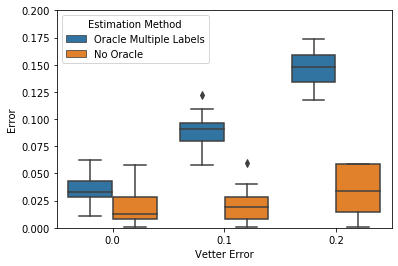

In [8]:
sns.boxplot(x='Vetter Error', y='Error', hue='Estimation Method', data=to_plot)
plt.ylim([0.0, 0.2])